In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from sklearn.model_selection import train_test_split

import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# own utils # TODO resolve namespace pollution by restricitn g importis in init
from utils.configuration import *
from utils.tram_models import *
from utils.tram_model_helpers import *
from utils.tram_data import *
from utils.loss_continous import *
from utils.tram_data_helpers import *
from scipy.special import logit

Train with GPU support.


# 1. Experiments and Paths

In [2]:
experiment_name = "working_version"   ## <--- set experiment name
seed=42
np.random.seed(seed)

LOG_DIR="/home/bule/TramDag/dev_experiment_logs"
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
DATA_PATH = EXPERIMENT_DIR # <----------- change to different source if needed
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

os.makedirs(EXPERIMENT_DIR,exist_ok=True)
# check if configration dict already exists if not create:

if os.path.exists(CONF_DICT_PATH):
    configuration_dict=load_configuration_dict(CONF_DICT_PATH)
    print(f"Loaded existing configuration from {CONF_DICT_PATH}")
else:
    configuration_dict=create_and_write_new_configuration_dict(experiment_name,CONF_DICT_PATH,EXPERIMENT_DIR,DATA_PATH,LOG_DIR)
    print(f"Created new configuration file at {CONF_DICT_PATH}")

Created new configuration file at /home/bule/TramDag/dev_experiment_logs/working_version/configuration.json


# 2.  Data

- same experiment as in https://arxiv.org/pdf/2503.16206 6.1 Conitnous Case
- provide data in the form of a pandas dataframe, if there are iamges add the paths to each image to the df

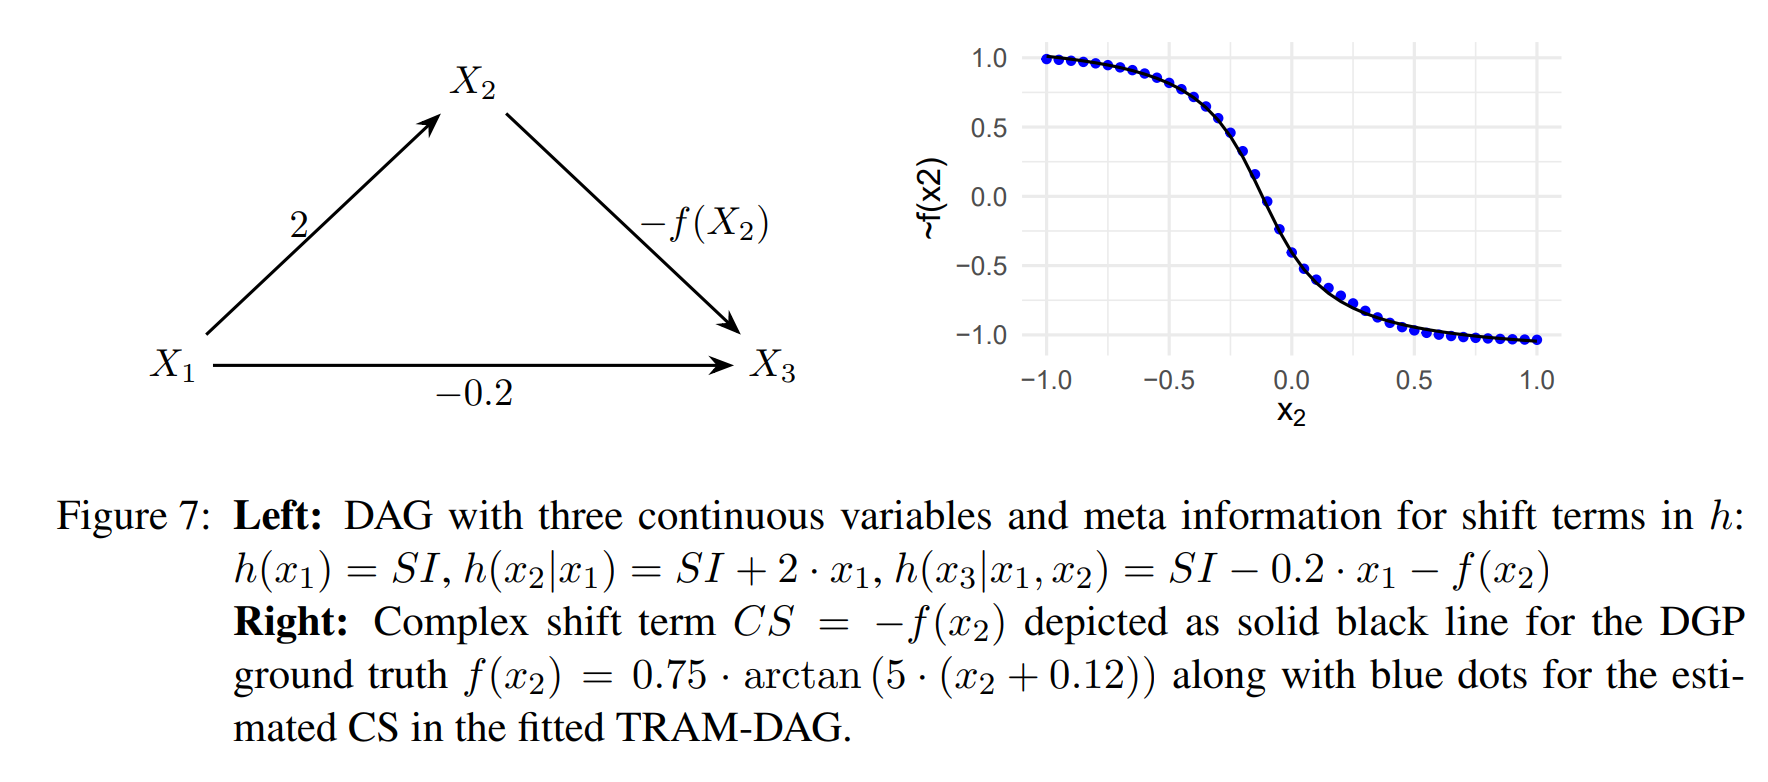

1. Linear-shift DGP and linear-shift model 

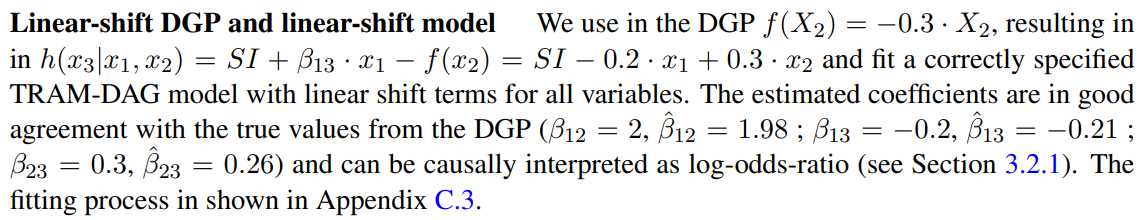

In [3]:
configuration_dict

{'date_of_creation': '2025-09-22 07:59:26',
 'experiment_name': 'working_version',
 'PATHS': {'DATA_PATH': '/home/bule/TramDag/dev_experiment_logs/working_version',
  'LOG_DIR': '/home/bule/TramDag/dev_experiment_logs',
  'EXPERIMENT_DIR': '/home/bule/TramDag/dev_experiment_logs/working_version'},
 'data_type': None,
 'adj_matrix': None,
 'model_names': None,
 'seed': None,
 'nodes': None}

Setting Seed: 42
         x1        x2        x3
0  0.696075 -0.301980 -1.183449
1  0.236174  0.092973  0.832250
2  0.700131 -0.540465 -2.323246
3  0.402303  0.103458  1.580181
4  0.789859 -0.372750 -0.066676
Variable 'x1' is modeled as a continuous variable. for target and predictor.
Variable 'x2' is modeled as a continuous variable. for target and predictor.
Variable 'x3' is modeled as a continuous variable. for target and predictor.
Configuration updated successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      10000 non-null  float64
 1   x2      10000 non-null  float64
 2   x3      10000 non-null  float64
dtypes: float64(3)
memory usage: 234.5 KB


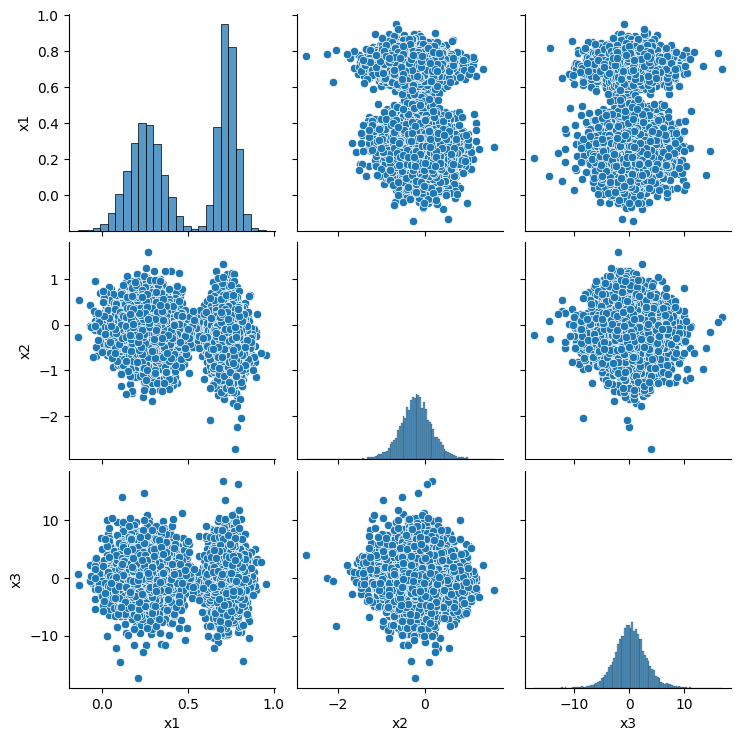

In [5]:
# 1. Linear-shift DGP and linear-shift model 
def f(x):
    return -0.3*x  

def dgp(n_obs, doX=[None, None, None], seed=-1):
    if seed > 0:
        np.random.seed(seed)
        print(f"Setting Seed: {seed}")
    
    # Generate x1 from a 2-component GMM
    
    # h(x1)= SI 
    
    
    if doX[0] is None:
        x1_A = np.random.normal(0.25, 0.1, n_obs)
        x1_B = np.random.normal(0.73, 0.05, n_obs)
        mix = np.random.choice([0, 1], size=n_obs)
        x1 = np.where(mix == 0, x1_A, x1_B)
    else:
        x1 = np.full(n_obs, doX[0])



    # Fz(z)=Fy(y)
    # Fz(h(y|x))=Fy(y)    | z= h(y|x)

    # Generate x2
    
    # h(x2|x1)= Bernsteinpol(x2) + beta2 * x1        | bernsteinpol is just linearized assumed with a constant factor say 0.42
    # h(x2|x1)= 0.42*x2 + beta2 * x1                 | replace h(x2|x1) with z
    # z       = 0.42*x2 + beta2 * x1                 | reformulate to x2
    # x2      = (z-beta2 * x1 )/0.42                 | sample z from standart logistic via uniform and logit(np.random.uniform(size=n_obs))
    # x2      = (z-beta2 * x1 )/0.42                 | set beta = 2 (on the edge of the graph)
    # x2      = (z-2 * x1 )/0.42                     |
    
    if doX[1] is None:
        u2 = np.random.uniform(size=n_obs)
        z2 = logit(u2)
        x2 = (z2 - 2 * x1) / 5#5#   0.42  in the trainagle strucutred cont last line is 5 for SI
    else:
        x2 = np.full(n_obs, doX[1])

    # Generate x3
    
    # h(x3|x2,x1)= Bernsteinpol(x3) + beta3 * x1 -f(X2)        | bernsteinpol is just linearized assumed with a constant factor say 0.63
    # h(x3|x2,x1)= 0.63*x3 + beta3 * x1          - f(X2)        | replace h(x2|x1) with z
    # z3          = 0.63*x3 + beta3 * x1          - f(X2)        | reformulate to x2
    # x3         = (z3-beta3 * x1 +f(X2))/0.63                   | sample z from standart logistic via uniform and logit(np.random.uniform(size=n_obs))
    # x3         = (z3-beta3 * x1 +f(X2))/0.63                   | set beta = -0.2 (on the edge of the graph)
    # x3         = (z3+0.2 * x1   +f(X2))/0.63                   | 

    
    if doX[2] is None:
        u3 = np.random.uniform(size=n_obs)
        z3 = logit(u3)
        x3 = (z3 + 0.2 * x1 + f(x2)) / 0.63
    else:
        x3 = np.full(n_obs, doX[2])
        
    #df = pd.DataFrame({'x1': x1, 'x2': x2})#, 'x3': x3})
    df = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3})
    return df

n_obs=10_000


EXP_DATA_PATH=os.path.join(EXPERIMENT_DIR, f"{experiment_name}.csv")

if not os.path.exists(EXP_DATA_PATH):
    df = dgp(n_obs=n_obs, seed=42)
    print(df.head())
    df.to_csv(EXP_DATA_PATH, index=False)
else:
    df = pd.read_csv(EXP_DATA_PATH)
    print(f"Loaded data from {EXP_DATA_PATH}")

sns.pairplot(df)

data_type= {'x1':'continous','x2':'continous','x3':'continous'} 

write_data_type_to_configuration(data_type, CONF_DICT_PATH)

df.info()

## 2.1 train test split

In [6]:
# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# 2. Compute quantiles from training data
quantiles = train_df.quantile([0.05, 0.95])
min_vals = quantiles.loc[0.05]
max_vals = quantiles.loc[0.95]

train_df.to_csv(os.path.join(EXPERIMENT_DIR, f"{experiment_name}_train.csv"), index=False)
val_df.to_csv(os.path.join(EXPERIMENT_DIR, f"{experiment_name}_val.csv"), index=False)
test_df.to_csv(os.path.join(EXPERIMENT_DIR, f"{experiment_name}_test.csv"), index=False)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")


Train size: 8000, Validation size: 1000, Test size: 1000


# 3. Define graph Structure

- define graph and which shift and intercept terms to use


In [7]:

interactive_adj_matrix(CONF_DICT_PATH,seed=10)

No matrix found. Please fill out the DAG and click 'Generate'.


# 4. Configuration for the Models

- all SI and LS model are generated outmatically since these are shallow NN's
- CI and CS have to be defined by the User and can be Passed for each model, -> generate default networks which are generated automaitcally

In [8]:
interactive_nn_names_matrix(CONF_DICT_PATH, seed=5)

In [9]:
levels_dict=create_levels_dict(df,data_type)

write_nodes_information_to_configuration(CONF_DICT_PATH, min_vals, max_vals,levels_dict)

{'x1': {'Modelnr': 0, 'data_type': 'continous', 'node_type': 'source', 'parents': [], 'parents_datatype': {}, 'transformation_terms_in_h()': {}, 'min': 0.12064138174529282, 'max': 0.7927992044799329, 'batch_size': 512, 'epochs': 100, 'learning_rate': 0.01, 'use_scheduler': False, 'transformation_term_nn_models_in_h()': {}}, 'x2': {'Modelnr': 1, 'data_type': 'continous', 'node_type': 'internal', 'parents': ['x1'], 'parents_datatype': {'x1': 'continous'}, 'transformation_terms_in_h()': {'x1': np.str_('ls')}, 'min': -0.8113477003510517, 'max': 0.42184081579848054, 'batch_size': 512, 'epochs': 100, 'learning_rate': 0.01, 'use_scheduler': False, 'transformation_term_nn_models_in_h()': {'x1': np.str_('LinearShift')}}, 'x3': {'Modelnr': 2, 'data_type': 'continous', 'node_type': 'sink', 'parents': ['x1', 'x2'], 'parents_datatype': {'x1': 'continous', 'x2': 'continous'}, 'transformation_terms_in_h()': {'x1': np.str_('ls'), 'x2': np.str_('ls')}, 'min': -4.428279471987848, 'max': 4.90898558615653

----------------------------------------------------------------------------------------------------------

In [10]:
# hyperparams:
train_list=['x1','x2','x3']#<-  set the nodes which have to be trained , useful if further training is required else lsit all vars
configuration_dict = load_configuration_dict(CONF_DICT_PATH)
# if you change the hyperparams -> write them to the config file!

In [12]:
# For each NODE 
node_list = configuration_dict['nodes'] 

for node in node_list:
    print(f'\n----*----------*-------------*--------------- Node: {node} ------------*-----------------*-------------------*--')

    ########################## 0. Get hyperparameters ###############################
    # batch_size, epochs, learning_rate, use_scheduler = get_hyperparameters_for_node(node,node_list)
    
    ############ Edited hyperparameters ##########
    batch_size = 512
    epochs = 500
    learning_rate = 0.01
    use_scheduler = False
    ###########################################
    
    print(f"Using hyperparameters: batch_size={batch_size}, epochs={epochs}, learning_rate={learning_rate}, use_scheduler={use_scheduler}\n")
    
    ########################## 1. Skip nodes ###############################
    if node not in train_list:# Skip if node is not in train_list
        print(f"Skipping node {node} as it's not in the training list.")
        continue
    if (node_list[node]['node_type'] == 'source') and (node_list[node]['node_type'] == 'other'):# Skip unsupported types
        print(f"Node type : other , is not supported yet")
        continue

    ########################## 2. Setup Paths ###############################
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    os.makedirs(NODE_DIR, exist_ok=True)
    

    ########################## 3. Check if training is complete ###############################
    if not check_if_training_complete(node, NODE_DIR, epochs):
        continue
    
    ########################## 4. Create Model ##############################
    tram_model= get_fully_specified_tram_model(node, configuration_dict, debug=True, set_initial_weights=True)
    
    ########################## 5. Create Dataloaders ########################
    train_loader, val_loader = get_dataloader(node, node_list, train_df, val_df, batch_size=batch_size,return_intercept_shift=True, debug=False)

    ########################## 6. Optimizer & Scheduler ######################.
    optimizer =torch.optim.Adam(tram_model.parameters(), lr=learning_rate)
    
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    else:
        scheduler = None

    ########################## 7. Training Loop ##############################
    
    train_val_loop(
                node,
                node_list,
                NODE_DIR,
                tram_model,
                train_loader,
                val_loader,
                epochs,
                optimizer,
                use_scheduler,
                scheduler,
                save_linear_shifts=True,
                verbose=1,
                device=device,
                debug=False) # TODO startvalues for bernsteinpols




----*----------*-------------*--------------- Node: x1 ------------*-----------------*-------------------*--
Using hyperparameters: batch_size=512, epochs=500, learning_rate=0.01, use_scheduler=False

[DEBUG] R script written to: /tmp/tmphp7cnu8x.R
[DEBUG] R code:
 
library(MASS)
library(tram)
library(readr)

data <- read_csv("/home/bule/TramDag/dev_experiment_logs/working_version/working_version_train.csv")
model <- Colr(x1 ~ 1, data=data, order=19)
cat(model$theta, sep="\n")

[DEBUG] Rscript succeeded
[DEBUG] STDOUT:
 -2.260622
-1.770482
-1.008906
-1.008906
-0.8327761
-0.08205439
-0.08205438
-0.0457422
-0.04574219
-0.04574217
-0.04574216
-0.04574215
-0.04574213
-0.04574212
-0.0457421
-0.04574209
-0.04574207
0.2845757
1.282277
2.278818

[INFO] Initialized intercept model with preinitialized weights: SimpleIntercept(
  (fc): Linear(in_features=1, out_features=20, bias=False)
)
No existing model found. Starting fresh...


/home/bule/TramDag/utils/tram_model_helpers.py:316: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_tilde = torch.tensor(theta_tilde, dtype=last_linear.weight.dtype, device=last_linear.weight.device)


Saved new best model.
Epoch 1/500  Train NLL: 2.0505  Val NLL: 1.9813  [Train: 0.62s  Val: 0.21s  Total: 0.84s]
Saved new best model.
Epoch 2/500  Train NLL: 1.9416  Val NLL: 1.8754  [Train: 0.43s  Val: 0.21s  Total: 0.64s]
Saved new best model.
Epoch 3/500  Train NLL: 1.8400  Val NLL: 1.7748  [Train: 0.39s  Val: 0.21s  Total: 0.60s]
Saved new best model.
Epoch 4/500  Train NLL: 1.7413  Val NLL: 1.6793  [Train: 0.40s  Val: 0.21s  Total: 0.61s]
Saved new best model.
Epoch 5/500  Train NLL: 1.6464  Val NLL: 1.5889  [Train: 0.39s  Val: 0.22s  Total: 0.62s]
Saved new best model.
Epoch 6/500  Train NLL: 1.5584  Val NLL: 1.5032  [Train: 0.44s  Val: 0.24s  Total: 0.68s]
Saved new best model.
Epoch 7/500  Train NLL: 1.4755  Val NLL: 1.4218  [Train: 0.45s  Val: 0.21s  Total: 0.66s]
Saved new best model.
Epoch 8/500  Train NLL: 1.3954  Val NLL: 1.3446  [Train: 0.44s  Val: 0.20s  Total: 0.64s]
Saved new best model.
Epoch 9/500  Train NLL: 1.3176  Val NLL: 1.2711  [Train: 0.37s  Val: 0.22s  Total:

/home/bule/TramDag/utils/tram_model_helpers.py:316: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_tilde = torch.tensor(theta_tilde, dtype=last_linear.weight.dtype, device=last_linear.weight.device)


Saved new best model.
Epoch 1/500  Train NLL: 3.0651  Val NLL: 2.9952  [Train: 0.40s  Val: 0.21s  Total: 0.61s]
Saved new best model.
Epoch 2/500  Train NLL: 2.9386  Val NLL: 2.8727  [Train: 0.41s  Val: 0.20s  Total: 0.61s]
Saved new best model.
Epoch 3/500  Train NLL: 2.8206  Val NLL: 2.7595  [Train: 0.48s  Val: 0.21s  Total: 0.69s]
Saved new best model.
Epoch 4/500  Train NLL: 2.7118  Val NLL: 2.6546  [Train: 0.44s  Val: 0.21s  Total: 0.65s]
Saved new best model.
Epoch 5/500  Train NLL: 2.6105  Val NLL: 2.5573  [Train: 0.44s  Val: 0.23s  Total: 0.67s]
Saved new best model.
Epoch 6/500  Train NLL: 2.5164  Val NLL: 2.4664  [Train: 0.44s  Val: 0.20s  Total: 0.64s]
Saved new best model.
Epoch 7/500  Train NLL: 2.4281  Val NLL: 2.3812  [Train: 0.43s  Val: 0.21s  Total: 0.64s]
Saved new best model.
Epoch 8/500  Train NLL: 2.3453  Val NLL: 2.3008  [Train: 0.41s  Val: 0.23s  Total: 0.64s]
Saved new best model.
Epoch 9/500  Train NLL: 2.2668  Val NLL: 2.2248  [Train: 0.48s  Val: 0.21s  Total:

/home/bule/TramDag/utils/tram_model_helpers.py:316: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_tilde = torch.tensor(theta_tilde, dtype=last_linear.weight.dtype, device=last_linear.weight.device)


Saved new best model.
Epoch 1/500  Train NLL: 5.0919  Val NLL: 5.0188  [Train: 0.44s  Val: 0.23s  Total: 0.67s]
Saved new best model.
Epoch 2/500  Train NLL: 4.9694  Val NLL: 4.9010  [Train: 0.46s  Val: 0.26s  Total: 0.73s]
Saved new best model.
Epoch 3/500  Train NLL: 4.8563  Val NLL: 4.7929  [Train: 0.47s  Val: 0.21s  Total: 0.68s]
Saved new best model.
Epoch 4/500  Train NLL: 4.7529  Val NLL: 4.6938  [Train: 0.48s  Val: 0.24s  Total: 0.72s]
Saved new best model.
Epoch 5/500  Train NLL: 4.6572  Val NLL: 4.6023  [Train: 0.46s  Val: 0.23s  Total: 0.70s]
Saved new best model.
Epoch 6/500  Train NLL: 4.5688  Val NLL: 4.5172  [Train: 0.47s  Val: 0.24s  Total: 0.71s]
Saved new best model.
Epoch 7/500  Train NLL: 4.4863  Val NLL: 4.4371  [Train: 0.43s  Val: 0.24s  Total: 0.68s]
Saved new best model.
Epoch 8/500  Train NLL: 4.4080  Val NLL: 4.3614  [Train: 0.44s  Val: 0.22s  Total: 0.67s]
Saved new best model.
Epoch 9/500  Train NLL: 4.3339  Val NLL: 4.2891  [Train: 0.45s  Val: 0.20s  Total:

# 6 Inspect Training

## 6.1 Loss vs epochs

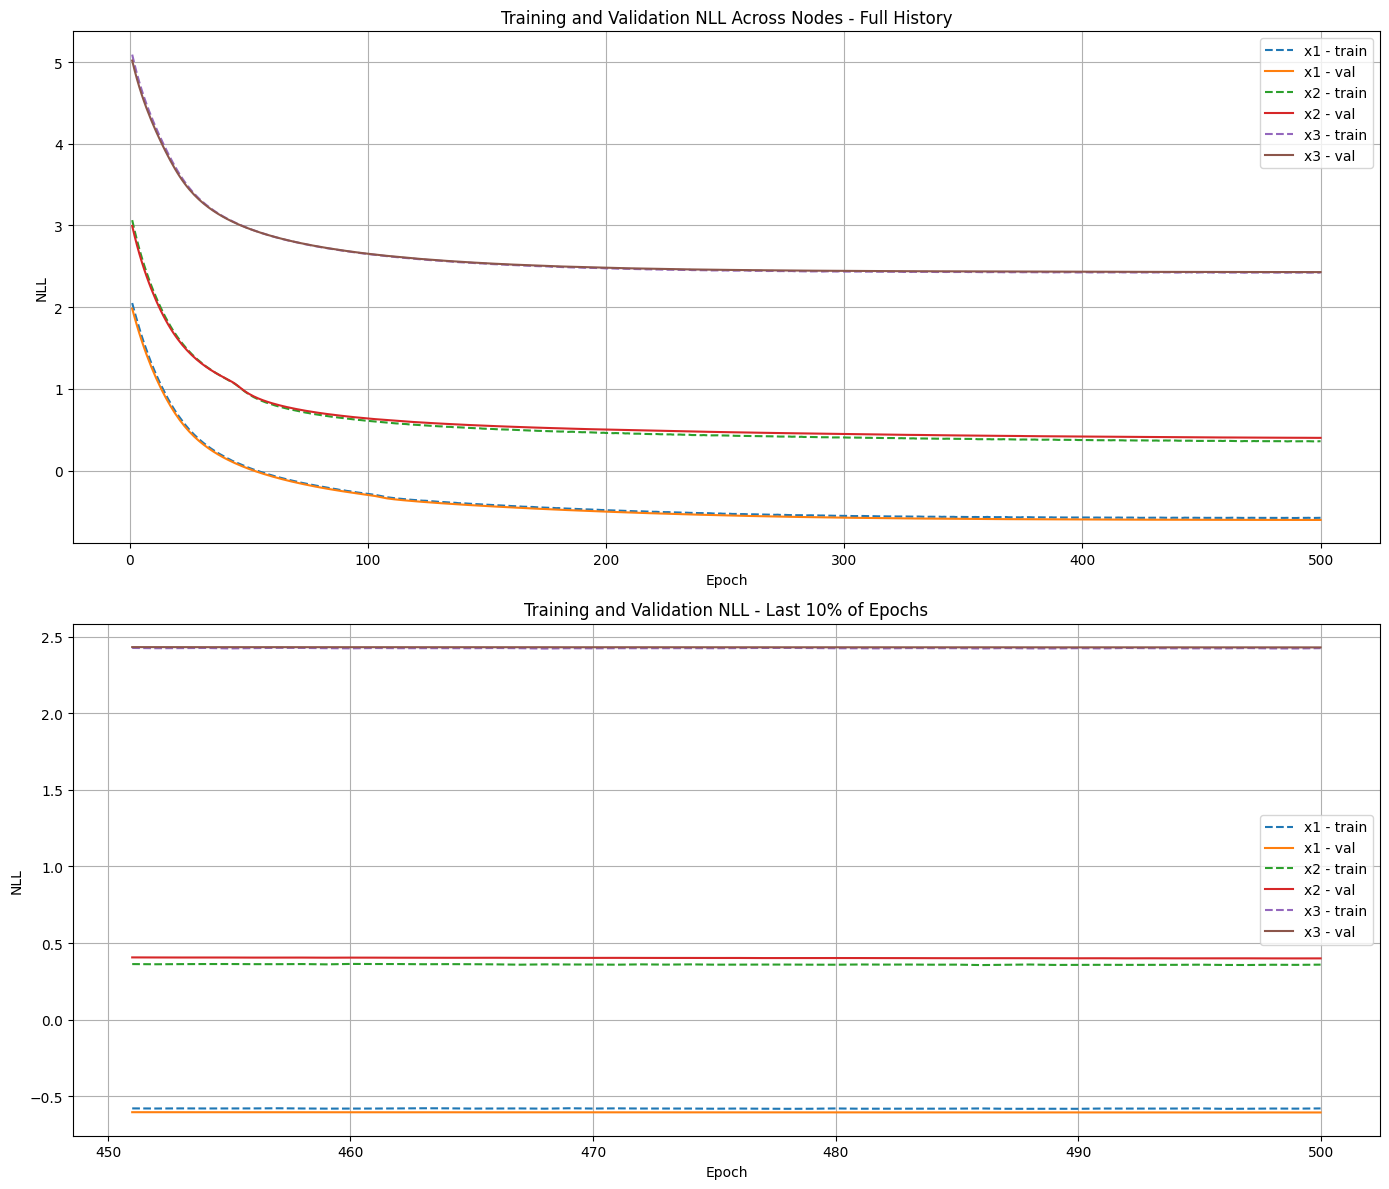

In [13]:
show_training_history(node_list,EXPERIMENT_DIR)

## 6.2 inspect transformation function for source nodes h()


----*----------*-------------*--------Inspect TRAFO Node: x1 ------------*-----------------*-------------------*--
[WARNING] target_col 'x1' not in DataFrame columns — is this intended for use as a Sampler?


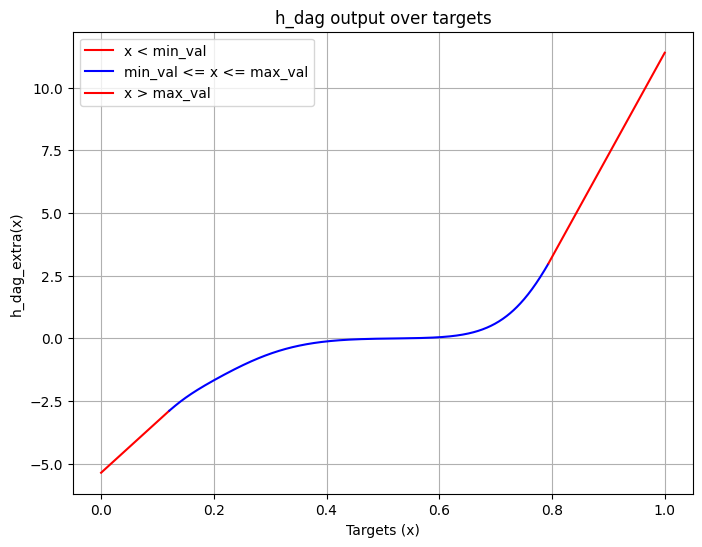

In [14]:
show_hdag_for_source_nodes(configuration_dict,EXPERIMENT_DIR,device=device,xmin_plot=0,xmax_plot=1) # TODO for other nodes funciton

----*----------*-------------*--------h(data) should be standard logistic: x1 ------------*-----------------*-------------------*--


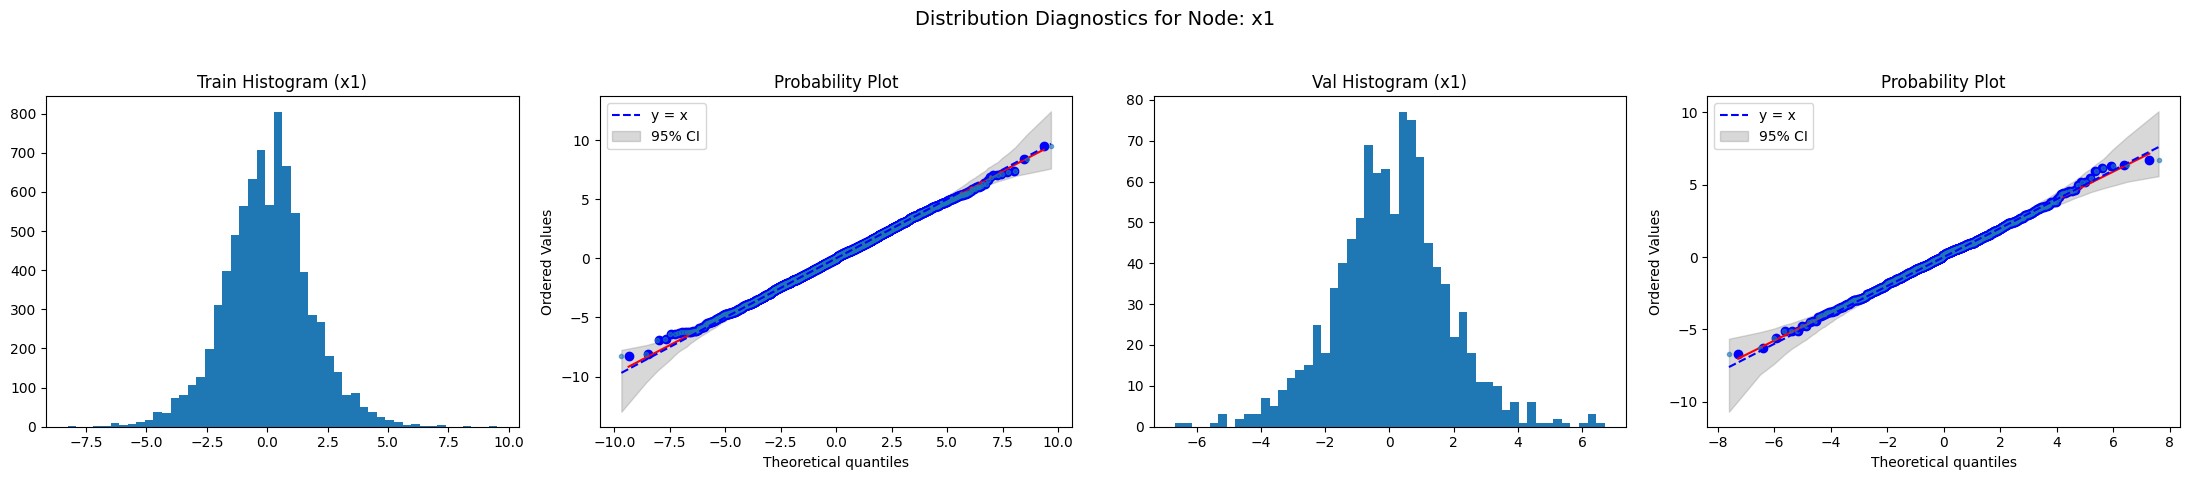

----*----------*-------------*--------h(data) should be standard logistic: x2 ------------*-----------------*-------------------*--


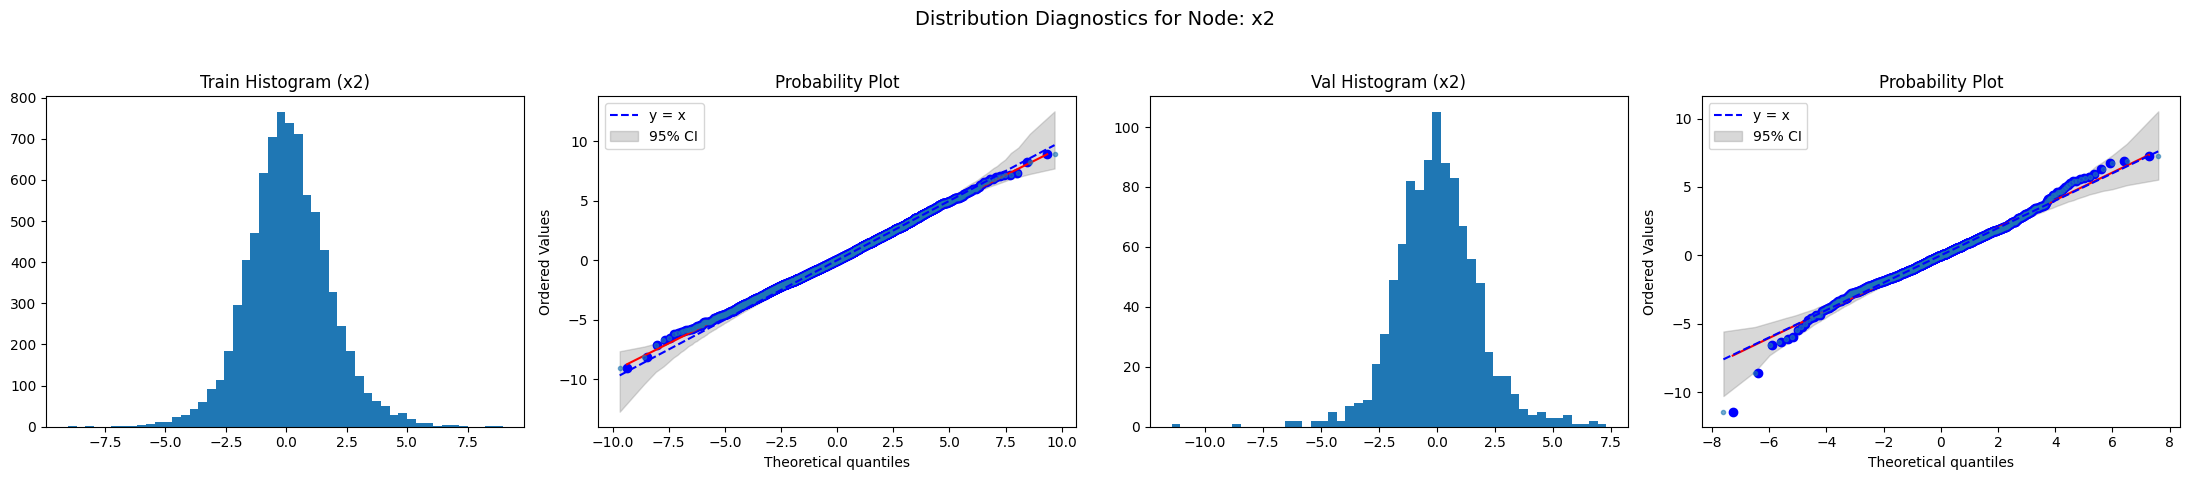

----*----------*-------------*--------h(data) should be standard logistic: x3 ------------*-----------------*-------------------*--


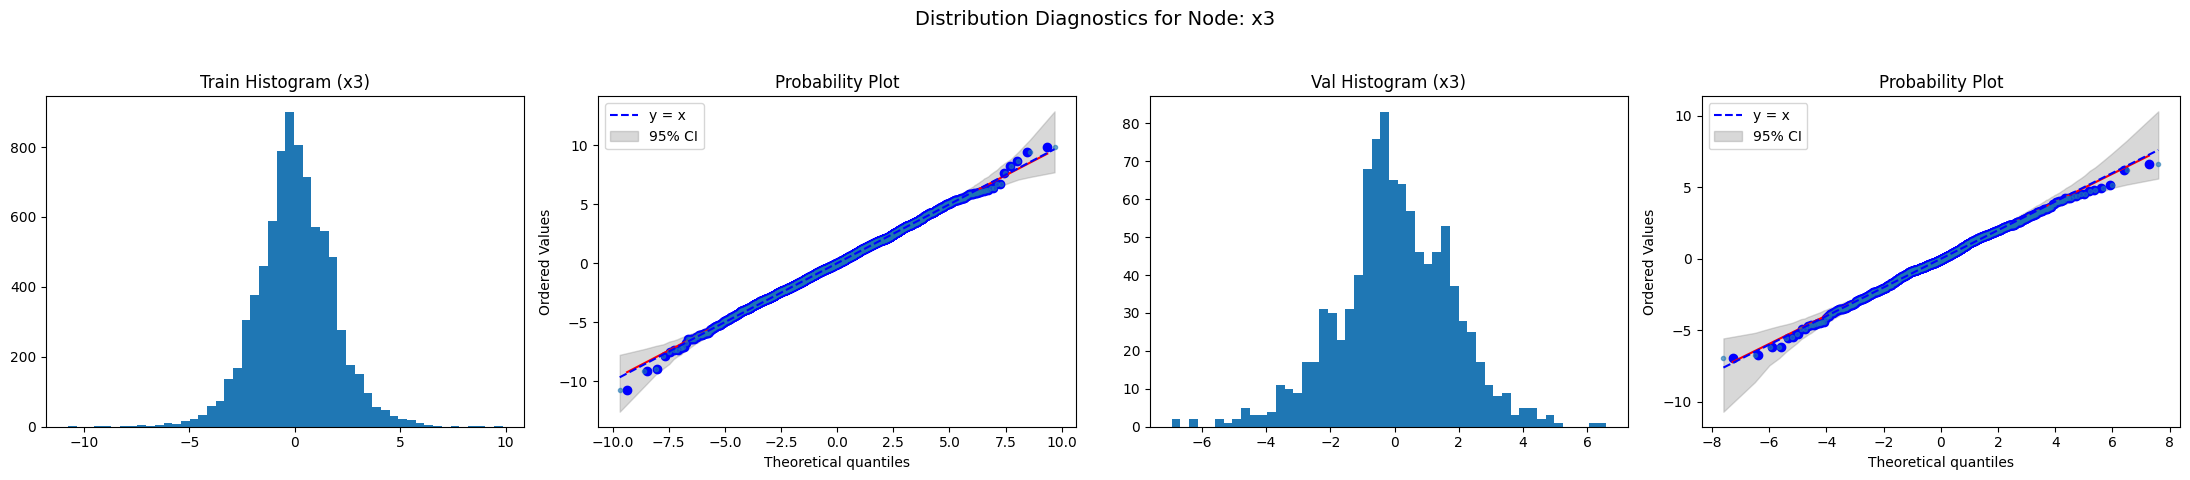

(array([[ 3.1065507 , -3.1035109 , -0.58012253],
        [-2.676726  ,  2.6105325 ,  0.61420876],
        [ 0.39822453, -0.5042095 , -2.2322392 ],
        ...,
        [-0.29158542,  2.119298  ,  1.8433323 ],
        [-0.24955003, -1.0681413 ,  0.16798496],
        [ 1.0368217 , -0.01750338, -1.1109931 ]], dtype=float32),
 array([[-0.45069098,  2.2851233 ,  0.74835455],
        [-0.41708428, -0.7639843 ,  3.5963755 ],
        [-1.0498447 , -0.5458771 ,  1.6375183 ],
        ...,
        [-0.34384423,  0.50663114,  1.028843  ],
        [-0.23798743,  6.8610888 , -0.75577   ],
        [-1.2862717 , -0.31554788,  1.4058889 ]], dtype=float32))

In [15]:
inspect_trafo_standart_logistic(configuration_dict,EXPERIMENT_DIR,train_df,val_df,device,verbose=False)

In [16]:

def provide_latents_for_input_data(
    node,
    configuration_dict,
    EXPERIMENT_DIR,
    data_loader,
    base_df,
    verbose=False
):
    """
    Compute latent representations for each observation in base_df
    and return a DataFrame with columns [node, "_U"] aligned with base_df.
    """
    
    target_nodes = configuration_dict["nodes"]
    if is_outcome_modelled_ordinal(node, target_nodes):
        raise ValueError("Not yet defined for ordinal target variables")

    #### 0. Paths
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f"{node}")

    ##### 1. Load model 
    model_path = os.path.join(NODE_DIR, "best_model.pt")
    tram_model = get_fully_specified_tram_model(
        node, configuration_dict, debug=verbose, set_initial_weights=False
    )
    tram_model = tram_model.to(device)
    tram_model.load_state_dict(torch.load(model_path, map_location=device))
    tram_model.eval()

    #### 2. Forward Pass
    min_vals = torch.tensor(target_nodes[node]["min"], dtype=torch.float32, device=device)
    max_vals = torch.tensor(target_nodes[node]["max"], dtype=torch.float32, device=device)
    min_max = torch.stack([min_vals, max_vals], dim=0)

    latents_list = []
    with torch.no_grad():
        for (int_input, shift_list), y in data_loader:
            # Move everything to device
            int_input = int_input.to(device)
            shift_list = [s.to(device) for s in shift_list]
            y = y.to(device)  # targets to device
            y_pred = tram_model(int_input=int_input, shift_input=shift_list)

            latents, _ = contram_nll(y_pred, y, min_max=min_max, return_h=True)
            latents_list.extend(latents.cpu().numpy())

    # Turn into DataFrame aligned with base_df
    latents_df = pd.DataFrame({
        node: base_df[node].values,
        "_U": latents_list
    }, index=base_df.index)

    return latents_df


# Example usage
train_latents_ds = GenericDataset(
    train_df, target_col=node, target_nodes=configuration_dict["nodes"]
)
train_latents_ds_loader = DataLoader(
    train_latents_ds, batch_size=4112, shuffle=False, num_workers=4, pin_memory=True
)

train_latents_df = provide_latents_for_input_data(
    node,
    configuration_dict,
    EXPERIMENT_DIR,
    train_latents_ds_loader,
    base_df=train_df,
    verbose=False
)


In [17]:
train_latents_df

,x3,_U
9254,1.361409,0.477880
1561,1.854532,1.076840
1670,-3.312690,-1.981525
6087,-0.759672,-0.502901
6669,1.989365,1.175399
...,...,...
5734,-1.704776,-1.094647
5191,-2.692297,-1.740238
5390,-0.293505,-0.481786
860,0.168432,-0.166136


### a function which returns all the latents for input data

provide_latents_for_input_data()




### Coefficient estimates


----*----------*-------------*--------check LS of x1 ------------*-----------------*-------------------*--
Node type :source

----*----------*-------------*--------check LS of x2 ------------*-----------------*-------------------*--


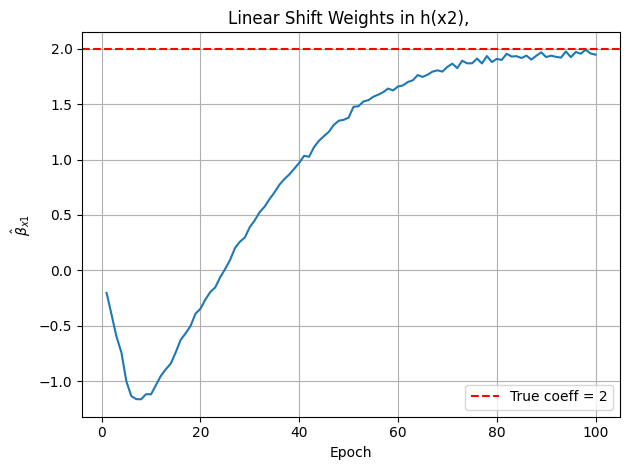


----*----------*-------------*--------check LS of x3 ------------*-----------------*-------------------*--


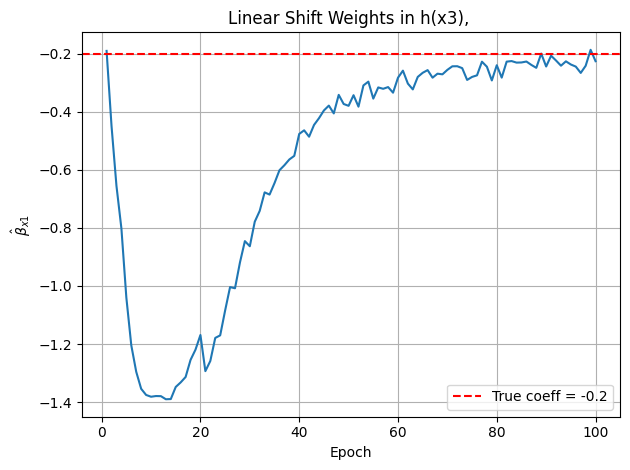

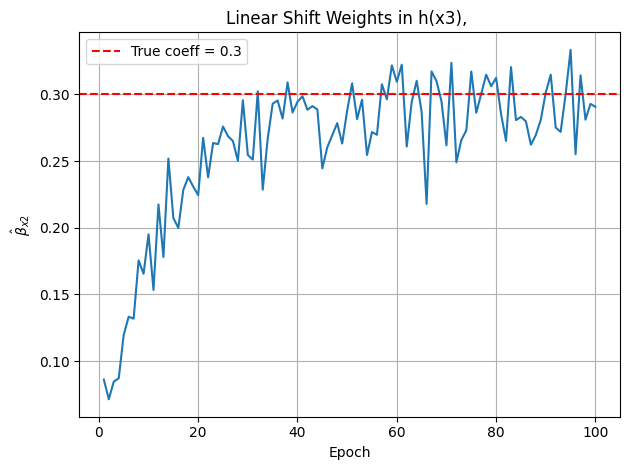

In [14]:
# x1-> x2, x1-> x3, x2-> x3
true_coeffs = {'x2': [2],'x3': [-0.2, 0.3]}

for node in node_list:
    print(f'\n----*----------*-------------*--------check LS of {node} ------------*-----------------*-------------------*--')
    
    if node_list[node]['node_type'] == 'source':
        print(f"Node type :source")
        continue
    
    # Paths
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    # Load saved shifts
    shift_path = os.path.join(NODE_DIR, "linear_shifts_all_epochs.json")
    with open(shift_path, 'r') as f:
        all_shift_weights = json.load(f)

    # Sort epochs numerically
    epochs = sorted(all_shift_weights.keys(), key=lambda x: int(x.split('_')[1]))

    # Number of shifts (incoming edges) for this node
    example_epoch = all_shift_weights[epochs[0]]
    num_shifts = len(example_epoch)

    # Plot per shift (incoming edge)
    for shifts_idx in range(num_shifts):
        shift_name = f"shift_{shifts_idx}"
        weights_over_time = []

        for epoch in epochs:
            weight_matrix = np.array(all_shift_weights[epoch][shift_name])  # shape: [out_features, in_features]
            avg_weight = weight_matrix.mean()
            weights_over_time.append(avg_weight)

        plt.figure()
        plt.plot(range(1, len(epochs) + 1), weights_over_time)

        # If this node has a true coefficient for this shift, draw a horizontal red line
        if node in true_coeffs:
            true_val = true_coeffs[node][shifts_idx]
            plt.axhline(y=true_val, color='r', linestyle='--', label=f"True coeff = {true_val}")
            plt.legend()

        plt.title(f"Linear Shift Weights in h({node}), ")
        plt.xlabel("Epoch")
        plt.ylabel(fr'$\hat{{\beta}}_{{{node_list[node]["parents"][shifts_idx]}}}$')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

- best model , parameters

In [15]:
verbose=False
batch_size = 4112
for node in node_list:
    print(f'\n----*----------*-------------*--------check CS of {node} ------------*-----------------*-------------------*--')
    
    if (node_list[node]['node_type'] == 'source'):
        print(f"Node type : other , is not supported yet")
        continue
    #### 0. Paths
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    
    ##### 1. Load model 
    model_path = os.path.join(NODE_DIR, "best_model.pt")
    tram_model = get_fully_specified_tram_model(node, configuration_dict, debug=verbose)
    tram_model = tram_model.to(device)
    tram_model.load_state_dict(torch.load(model_path))
    tram_model.eval()
    
        
    for i in range(len(tram_model.nn_shift)):
        print(tram_model.nn_shift[i].fc.weight.data)
    


----*----------*-------------*--------check CS of x1 ------------*-----------------*-------------------*--
Node type : other , is not supported yet

----*----------*-------------*--------check CS of x2 ------------*-----------------*-------------------*--
tensor([[1.9909]], device='cuda:0')

----*----------*-------------*--------check CS of x3 ------------*-----------------*-------------------*--
tensor([[-0.2263]], device='cuda:0')
tensor([[0.2908]], device='cuda:0')


# 7. Sample from Graph

In [16]:
sample_full_dag(configuration_dict,
                EXPERIMENT_DIR,
                device,
                do_interventions={},
                number_of_samples= 10_000,
                batch_size = 32,
                delete_all_previously_sampled=True,
                verbose=True,
                debug=False)

[INFO] Deleting all previously sampled data.
Deleted directory: /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_ls_new/x1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_ls_new/x2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_ls_new/x3/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[WARNING] target_col 'x1' not in DataFrame columns — is this intended for use as a Sampler?


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:31<00:00, 317.87it/s]

[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[WARNING] target_col 'x2' not in DataFrame columns — is this intended for use as a Sampler?



Chandrupatla root finding: 100%|██████████| 10000/10000 [00:31<00:00, 317.29it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[WARNING] target_col 'x3' not in DataFrame columns — is this intended for use as a Sampler?



Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 328.86it/s]

[INFO] Completed sampling for node 'x3'
[INFO] DAG sampling completed successfully for all nodes.


## 7.3 Inspect Sampling

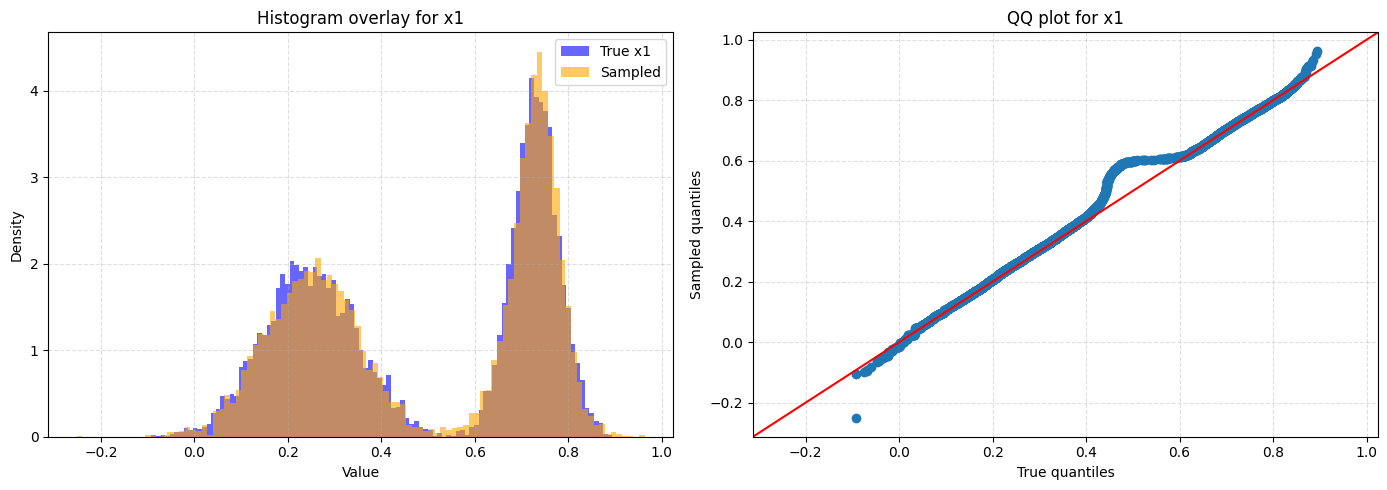

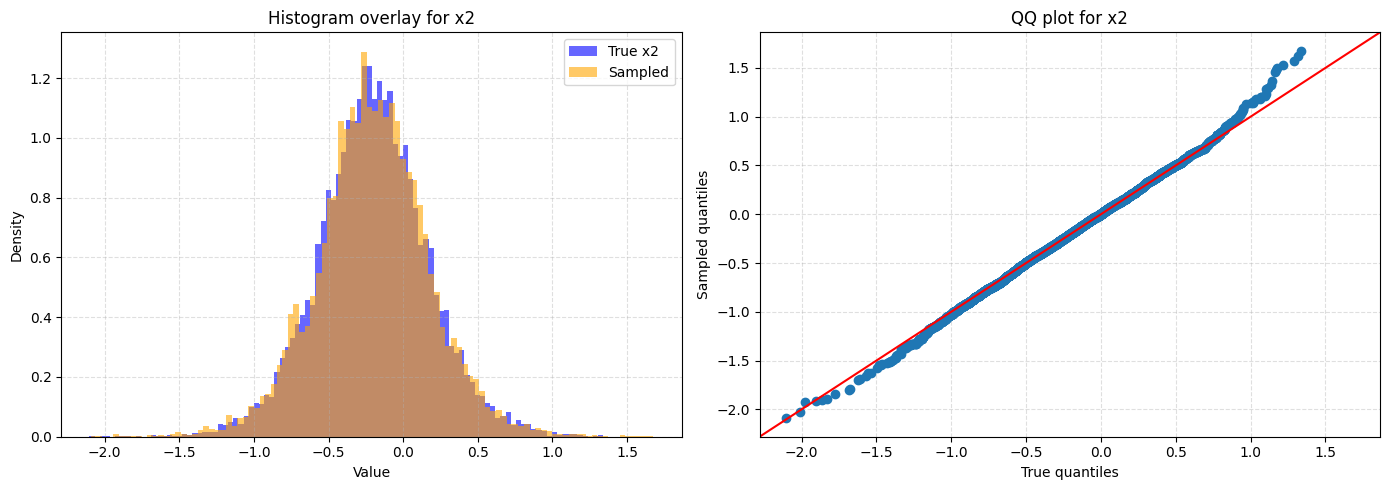

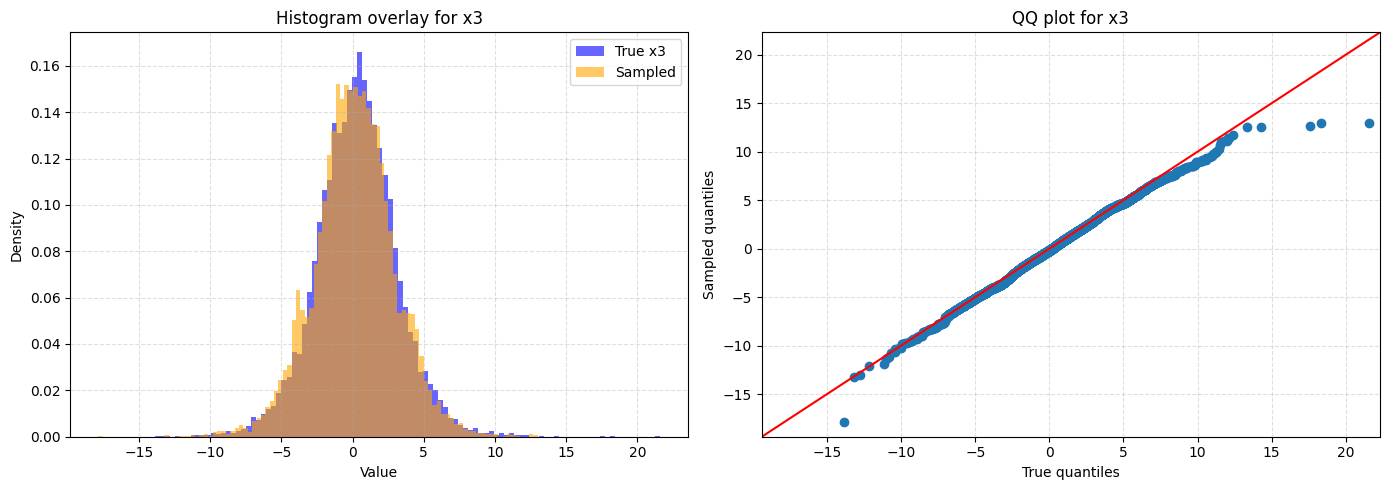

In [17]:
show_samples_vs_true(test_df,node_list,EXPERIMENT_DIR)